# Práctica 3 - Parte 2: Simulación Monte Carlo

## 📝 Enunciado
Este notebook contiene **dos ejercicios** de simulación **Monte Carlo**:

1. **Estimación de π** por muestreo uniforme en el cuadrado y conteo de puntos en el círculo inscrito. Además, se debe **graficar** el cuadrado, el círculo y los puntos **dentro** y **fuera** del círculo en colores distintos.

2. **Propagación de incertidumbre** en el **modelo cinemático** de un robot móvil diferencial con entradas fijas $v,\,\omega$ (trayectoria nominal curva). Se pide **añadir incertidumbre** (ruido) a $v$ y $\omega$, simular por Monte Carlo y **estimar la covarianza** de la pose final $(x, y, \theta))$.

---

## ✍️ Ejercicio 1 — Estimación de π con Monte Carlo


- Genera $N$ puntos $(x_i, y_i)$ **uniformes** en el cuadrado $[-1,1]\times[-1,1]$.
- Cuenta cuántos caen **dentro** del círculo de radio 1 centrado en el origen: $x_i^2 + y_i^2 \le 1$.
- Estima $\pi$ como $\hat{\pi} = 4\,n_{\text{dentro}}/N$.
- **Grafica**: el cuadrado, el círculo y los puntos dentro/fuera en **colores distintos**.
- Reporta la estimación de $\pi$, el error absoluto y relativo respecto del valor real.


---

## ✍️ Ejercicio 2 — Propagación de incertidumbre en un robot móvil (modelo cinemático)
**Modelo.** Robot diferencial en el plano con entradas lineal $v$ y angular $\omega$ constantes durante cada paso de integración $\Delta t$:


\begin{aligned}
x_{k+1} &= x_k + v\,\cos(\theta_k)\,\Delta t,\\
y_{k+1} &= y_k + v\,\sin(\theta_k)\,\Delta t,\\
\theta_{k+1} &= \theta_k + \omega\,\Delta t.
\end{aligned}


**Enunciado.**

1. Simula la **trayectoria nominal** durante $T$ segundos con $\Delta t$, usando $v$ y $\omega$ constantes.

2. Introduce **incertidumbre** en $v$ y $\omega$: para cada simulación Monte Carlo, toma $v \sim \mathcal{N}(\bar v, \sigma_v^2)$ y $\omega \sim \mathcal{N}(\bar\omega, \sigma_\omega^2)$ (truncando si es necesario para evitar valores no físicos).

3. Ejecuta $M$ simulaciones, recopila la **pose final** $(x_T, y_T, \theta_T)$ y estima la **covarianza muestral** de la pose final.

4. **Grafica**: la trayectoria nominal y varias trayectorias muestrales. Dibuja también la **elipse de covarianza** en $(x_T, y_T)$.

5. Reporta la media muestral y la matriz de covarianza estimada.



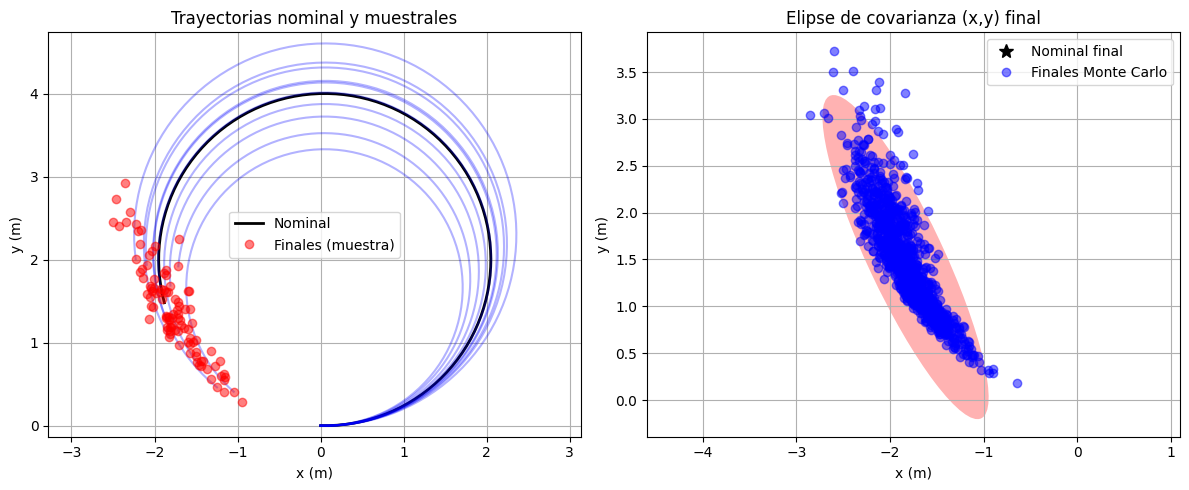

Media muestral de la pose final:
x: -1.8337 ± 0.2956
y: 1.5255 ± 0.5764
θ: 4.9996 ± 0.2507 rad

Matriz de covarianza estimada:
[[ 0.08737584 -0.14740227  0.0555268 ]
 [-0.14740227  0.33228887 -0.13775115]
 [ 0.0555268  -0.13775115  0.06287367]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import math

# Parámetros de la simulación
T = 10.0  # Tiempo total en segundos
dt = 0.1  # Paso de tiempo
v_bar = 1.0  # Velocidad lineal nominal (m/s)
omega_bar = 0.5  # Velocidad angular nominal (rad/s)
sigma_v = 0.1 * v_bar  # Desviación estándar para v
sigma_omega = 0.05 * omega_bar  # Desviación estándar para omega
M = 1000  # Número de simulaciones Monte Carlo
N_steps = int(T / dt)  # Número de pasos

# Pose inicial
x0, y0, theta0 = 0.0, 0.0, 0.0

def simulate_trajectory(v, omega, dt, N_steps, initial_pose):
    """
    Simula una trayectoria usando el modelo cinemático.
    """
    x, y, theta = initial_pose
    trajectory = np.array([[x, y, theta]])
    for _ in range(N_steps):
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += omega * dt
        trajectory = np.vstack([trajectory, [x, y, theta]])
    return trajectory

# 1. Simulación de la trayectoria nominal
nominal_trajectory = simulate_trajectory(v_bar, omega_bar, dt, N_steps, (x0, y0, theta0))

# 2. y 3. Simulaciones Monte Carlo
final_poses = np.zeros((M, 3))  # Almacena poses finales [x, y, theta]
sample_trajectories = []  # Para graficar algunas trayectorias muestrales

for i in range(M):
    # Muestreo de v y omega con ruido gaussiano
    v_sample = np.random.normal(v_bar, sigma_v)
    omega_sample = np.random.normal(omega_bar, sigma_omega)
    
    # Evitar valores no físicos (opcional: truncar v >= 0)
    v_sample = max(0.0, v_sample)
    
    traj = simulate_trajectory(v_sample, omega_sample, dt, N_steps, (x0, y0, theta0))
    final_poses[i] = traj[-1]  # Pose final
    if i < 10:  # Guardar 10 trayectorias muestrales para graficar
        sample_trajectories.append(traj)

# Estimación de media y covarianza muestral
mean_pose = np.mean(final_poses, axis=0)
cov_pose = np.cov(final_poses.T)  # Covarianza de [x, y, theta]

# 4. Graficar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de trayectorias
ax1.plot(nominal_trajectory[:, 0], nominal_trajectory[:, 1], 'k-', linewidth=2, label='Nominal')
for traj in sample_trajectories:
    ax1.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.3)
ax1.plot(final_poses[:100, 0], final_poses[:100, 1], 'ro', alpha=0.5, label='Finales (muestra)')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Trayectorias nominal y muestrales')
ax1.legend()
ax1.grid(True)
ax1.axis('equal')

# Elipse de covarianza en (x,y)
cov_xy = cov_pose[:2, :2]  # Submatriz para x,y
mean_xy = mean_pose[:2]

# Función para dibujar elipse de confianza (3 sigma)
def plot_cov_ellipse(cov, mean, ax, n_std=3, **kwargs):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

plot_cov_ellipse(cov_xy, mean_xy, ax2, n_std=3, facecolor='red', alpha=0.3)
ax2.plot(nominal_trajectory[-1, 0], nominal_trajectory[-1, 1], 'k*', markersize=10, label='Nominal final')
ax2.plot(final_poses[:, 0], final_poses[:, 1], 'bo', alpha=0.5, label='Finales Monte Carlo')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('Elipse de covarianza (x,y) final')
ax2.legend()
ax2.grid(True)
ax2.axis('equal')

plt.tight_layout()
plt.show()

# 5. Reportar media y covarianza
print("Media muestral de la pose final:")
print(f"x: {mean_pose[0]:.4f} ± {np.sqrt(cov_pose[0,0]):.4f}")
print(f"y: {mean_pose[1]:.4f} ± {np.sqrt(cov_pose[1,1]):.4f}")
print(f"θ: {mean_pose[2]:.4f} ± {np.sqrt(cov_pose[2,2]):.4f} rad")
print("\nMatriz de covarianza estimada:")
print(cov_pose)
